# Brownian Motion

Two tasks: 
* What's the volatility of each node? (graph independent)
* What's the natural frequency of each node? (graph dependent)

Create simulation

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
from pygsig.graph import StaticGraphTemporalSignal
import torch_geometric.transforms as T
from pygsig.signature import SignatureFeatures, StatFeatures

# Simulation parameters
num_nodes = 200
dim = 2
time_horizon = 10
dt = 1e-2
num_time_steps = int(time_horizon / dt)
beta_gain = 5
sigma_gain = 1

def run_simultion(simulation_seed=1,target_seed=29,graph_seed=29):

    def kuramoto(graph, theta, omega, dt):
        deg = dict(graph.degree())
        dtheta = np.zeros_like(theta)
        for u, v, data in graph.edges(data=True):
            coupling = data['weight']
            dtheta[u] += dt * (omega[u]  + (1/deg[u]) * coupling * np.sin(theta[v] - theta[u]))
            dtheta[v] += dt * (omega[v]  + (1/deg[v]) * coupling * np.sin(theta[u] - theta[v]))
        return theta + dtheta

    def periodic_drift(beta, theta, omega,mu_0, t):
        return mu_0 + beta*np.sin(omega*t + theta)

    # Create a graph

    block_sizes = [num_nodes//2,num_nodes//2]
    block_probs = [[0.1,0.05],[0.05,0.1]]
    graph = nx.stochastic_block_model(block_sizes, block_probs, seed=graph_seed)

    for edge in graph.edges:
        graph[edge[0]][edge[1]]['weight'] = np.random.rand()
    
    for node in graph.nodes:
        if graph.nodes[node]['block'] == 0:
            graph.nodes[node]['omega'] = max(0.05*np.random.randn()+0.2,0)
        if graph.nodes[node]['block'] == 1:
            graph.nodes[node]['omega'] = min(0.05*np.random.randn()+0.8,1)
    # Nature frequency (target variable)
    np.random.seed(target_seed)
    
    # Othe oscilator perameters
    np.random.seed(simulation_seed)
    omega = np.stack([np.ones(dim) * graph.nodes[node]['omega'] for node in graph.nodes])
    theta = 2 * np.pi * np.random.rand(num_nodes,dim)  # Initial phases
    beta =  beta_gain * np.ones((num_nodes,dim)) # amplitude
    mu_initial = np.random.rand(num_nodes,dim) # initial drift

    # brownian motion parameters
    X = np.random.rand(num_nodes,dim) # signal
    drift = np.random.rand(num_nodes,dim) # drift
    sigma = sigma_gain * np.eye(dim) # diffusion matrix

    # Simulate
    theta_traj = np.zeros((num_nodes,num_time_steps,dim))
    mu_traj = np.zeros((num_nodes,num_time_steps,dim))
    paths = np.zeros((num_nodes,num_time_steps, dim))

    # Time sequence
    tt = np.linspace(0, time_horizon, num_time_steps)

    for step,t in enumerate(tt):
        theta_traj[:, step] = theta
        mu_traj[:,step] = drift
        paths[:,step,:] = X
        theta = kuramoto(graph, theta, omega,dt)
        drift = periodic_drift(beta, theta,omega, mu_initial, t)
        X = X + dt * drift + np.sqrt(dt) * np.random.randn(num_nodes,dim) @ sigma

    return paths, omega , graph

def get_sequence(paths,graph):
    snapshot_count = paths.shape[1]
    df_edge = nx.to_pandas_edgelist(graph.to_directed())
    edge_index = torch.tensor(df_edge[['source','target']].values.T,dtype=torch.long)
    edge_weight = torch.tensor(df_edge['weight'].values,dtype=torch.float)
    snapshot_count = paths.shape[1]
    features = [ paths[:,t,:] for t in range(snapshot_count)]
    targets = [ torch.tensor(np.array([graph.nodes[node]['omega'] for node in graph.nodes]),dtype=torch.float).unsqueeze(-1) for _ in range(snapshot_count)]
    # Sequential Data
    return StaticGraphTemporalSignal(edge_index=edge_index,edge_weight=edge_weight,features=features,targets=targets)


Make dataset consisting of multiple SDE trajectories

In [3]:
from tqdm import tqdm

num_runs = 1
seq_dataset = []
with tqdm(total=num_runs) as pbar:
    for run in range(num_runs):
        paths, omega, graph = run_simultion(simulation_seed=29+run,target_seed=29+run,graph_seed=29+run)
        seq_dataset.append(get_sequence(paths,omega,graph))
        pbar.update(1)

torch.save(seq_dataset,'datasets/brownian/brownian.pt')

100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


Plot trajectories

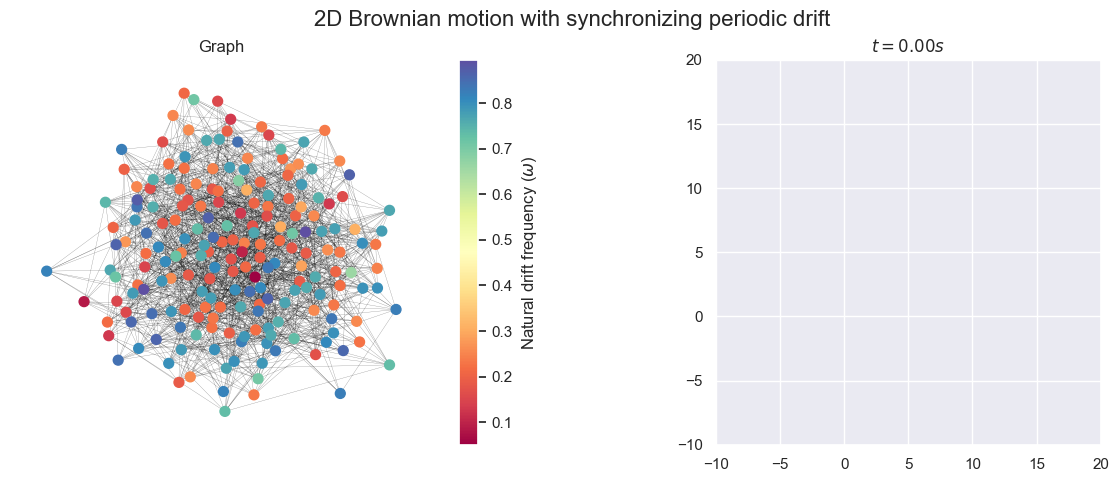

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.animation as animation

omega1d = np.array([graph.nodes[node]['omega'] for node in graph.nodes])

x_min, x_max = -10, 20
y_min, y_max = -10, 20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5),dpi=300)

# Plotting the graph
ax1.set_title('Graph')
ax1.axis('off')
pos = nx.spring_layout(graph, k=1, iterations=100)
nx.draw_networkx_nodes(graph, pos, node_color=omega1d, cmap='Spectral', node_size=50, ax=ax1)
nx.draw_networkx_edges(graph, pos, width=0.2, edge_color='black', alpha=0.5, ax=ax1)

# Title for the entire figure
fig.suptitle('2D Brownian motion with synchronizing periodic drift', fontsize=16)

# Colorbar for the natural frequencies
cmap = plt.cm.Spectral
sm = plt.cm.ScalarMappable(cmap=cmap)
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Natural drift frequency ($\\omega$)')

# Animation setup
ax2.set_aspect('equal')
ax2.axis('off')
ax2.grid(True)
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)


def animate_node(step, node):
    ax2.plot(paths[node, :step, 0], paths[node, :step, 1], color=cmap(omega1d[node]), linewidth=0.5, alpha=0.8)

def animate(step):
    ax2.cla()  # Clear the axis for the next frame
    ax2.grid(True)  # Re-enable grid after clearing
    ax2.set_aspect('equal')
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    for node in range(num_nodes):
        animate_node(step, node)
    ax2.set_title(f'$t = {step * dt:.2f}s$')

ani = animation.FuncAnimation(fig, animate, frames=num_time_steps, interval=10)
ani.save('plots/brownian.mp4', writer='ffmpeg',fps=60)

Model: GCNRegression
Number of parameters: 513


100%|██████████| 20/20 [01:24<00:00,  4.24s/it]


MSE: 0.0485 ± 0.0079, MAE: 0.1723 ± 0.0190 


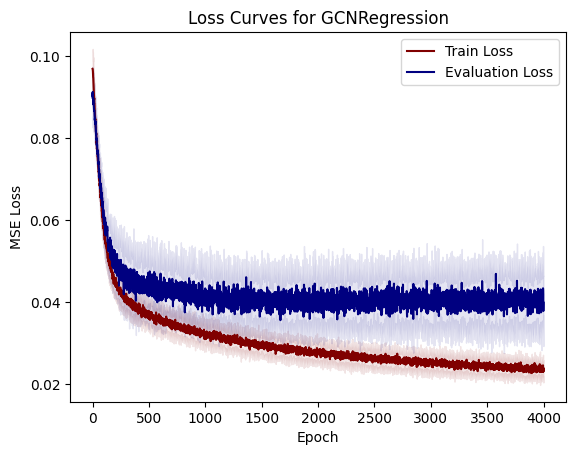

Model: ChebNetRegression
Number of parameters: 513


100%|██████████| 20/20 [00:54<00:00,  2.71s/it]

MSE: 0.0600 ± 0.0101, MAE: 0.1834 ± 0.0139 


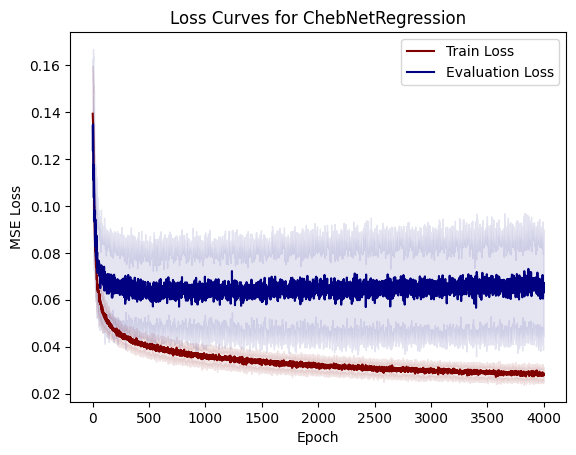

Model: ChebNetRegression
Number of parameters: 1009


100%|██████████| 20/20 [01:50<00:00,  5.55s/it]

MSE: 0.0410 ± 0.0073, MAE: 0.1594 ± 0.0139 


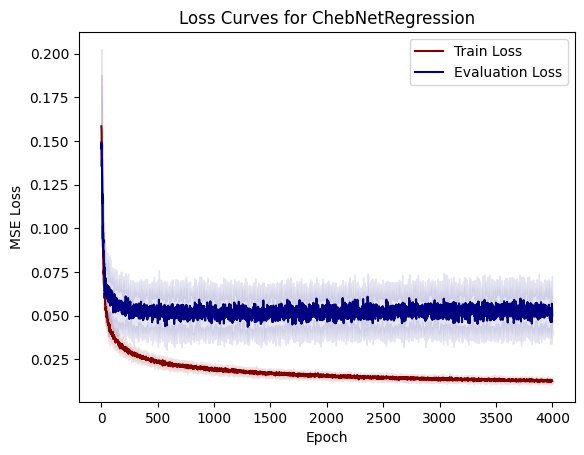

Model: ChebNetRegression
Number of parameters: 1505


100%|██████████| 20/20 [02:42<00:00,  8.12s/it]

MSE: 0.0434 ± 0.0114, MAE: 0.1638 ± 0.0199 


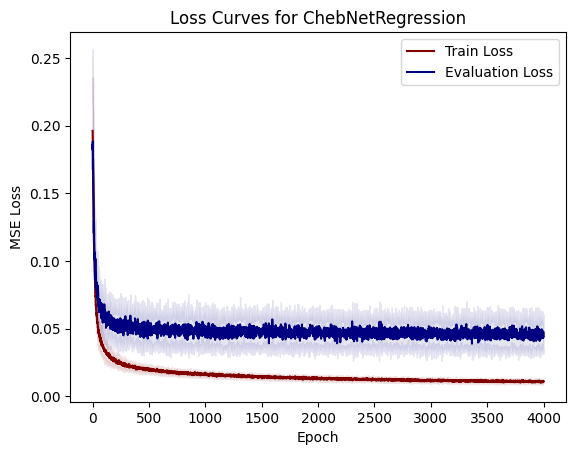

Model: ChebNetRegression
Number of parameters: 2001


100%|██████████| 20/20 [03:31<00:00, 10.58s/it]

MSE: 0.0495 ± 0.0131, MAE: 0.1708 ± 0.0166 


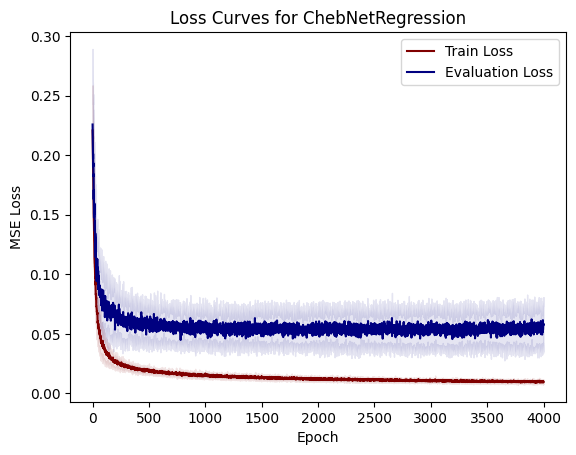

Model: MLPRegression
Number of parameters: 513


100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

MSE: 0.0549 ± 0.0114, MAE: 0.1783 ± 0.0145 


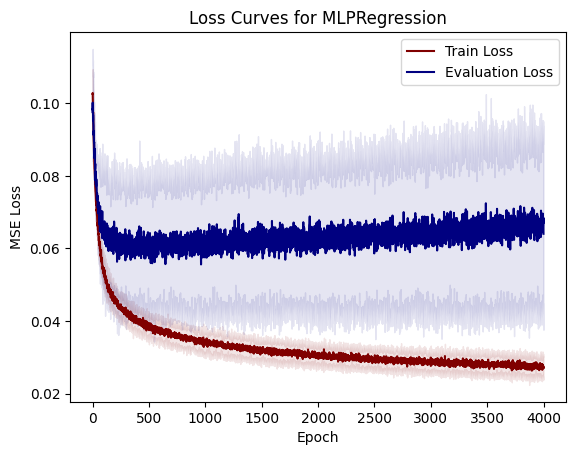

In [5]:
import torch
import torch.nn as nn
import signatory
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNRegression, MLPRegression, ChebNetRegression
from pygsig.graph import StaticGraphTemporalSignal, split_nodes
from pygsig.signature import SignatureFeatures

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

signature_depth = 4

dataset = []
for seq in seq_dataset:
    signature_transform = SignatureFeatures(sig_depth=signature_depth, normalize=True, log_signature=False,augment=False)
    dataset.append(signature_transform(seq))
data = dataset[0]

num_splits = 4
num_runs = len(dataset)
num_trials = 5
num_epochs = 4000

learning_rate = 1e-3
lasso = 0
num_hidden = 16

print_during_training = False

# initialize models
models = []
models += [GCNRegression(num_channels=[data.num_node_features, num_hidden, 1])]
models += [ChebNetRegression(num_channels=[data.num_node_features, num_hidden, 1], K=k) for k in [1,2,3,4]]
models += [MLPRegression(num_channels=[data.num_node_features, num_hidden, 1])]

mse_models = []
mae_models = []

for model in models:
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso)
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    mse = np.zeros([num_splits, num_runs, num_trials])
    mae = np.zeros([num_splits, num_runs, num_trials])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,seed=31)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, data in enumerate(dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        # train
                        model.train()
                        optimizer.zero_grad()
                        out = model(data.x, data.edge_index)
                        train_loss = criterion(out[train_mask], data.y[train_mask])
                        train_loss.backward()
                        optimizer.step()
                        # evaluate
                        model.eval()
                        with torch.no_grad():
                            eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                            train_losses[split, run, trial, epoch] = train_loss.item()
                            eval_losses[split, run, trial, epoch] = eval_loss.item()
                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Test MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)
                    with torch.no_grad():
                        out = model(data.x, data.edge_index)
                        mse[split, run, trial] = mean_squared_error(data.y[test_mask], out[test_mask])
                        mae[split, run, trial] = mean_absolute_error(data.y[test_mask], out[test_mask])

    print(f'MSE: {np.mean(mse):.4f} ± {np.std(mse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f} ')  
    mse_models.append(mse)
    mae_models.append(mae)

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2))
    avg_eval_losses = np.mean(eval_losses, axis=(0,1,2))
    std_train_losses = np.std(train_losses, axis=(0,1,2))
    std_eval_losses = np.std(eval_losses, axis=(0,1,2))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
    plt.plot(avg_eval_losses,  label='Evaluation Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1,color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Loss Curves for {model._get_name()}')
    plt.legend()
    plt.show()

In [6]:
MSE = np.array(mse_models)
MAE = np.array(mae_models)

Baseline

In [7]:
mse_base = []
mae_base = []
with torch.no_grad():
    mse_split = []
    mae_split = []
    for split in range(num_splits):
        train_indices, _, test_indices = splits[split]
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        train_mask[train_indices] = True
        test_mask[test_indices] = True

        mse_run = []
        mae_run = []
        for run,data in enumerate(dataset):
            mse_trial = []
            mae_trial = []
            for trial in range(num_trials):
                # Baseline
                out = torch.mean(data.y[train_mask]).item() * torch.ones(data.num_nodes)
                mse_trial.append( mean_squared_error(data.y[test_mask],out[test_mask]) )
                mae_trial.append( mean_absolute_error(data.y[test_mask],out[test_mask]) )
            mse_run.append(mse_trial)
            mae_run.append(mae_trial)
        mse_split.append(mse_run)
        mae_split.append(mae_run)
    mse_base.append(mse_split)
    mae_base.append(mae_split)
        

print('Model: Baseline')
print(f'Number of prameters: {0}')
print(f'{np.mean(mse_base):.4f} ± {np.std(mse_base):.4f}, MAE: {np.mean(mae_base):.4f} ± {np.std(mae_base):.4f} ')  


Model: Baseline
Number of prameters: 0
0.0990 ± 0.0073, MAE: 0.3109 ± 0.0119 


Add baselines to model

In [8]:
MSE = np.concatenate([MSE,np.array(mse_base)],axis=0)
MAE = np.concatenate([MAE,np.array(mae_base)],axis=0)

/var/folders/0b/l3krx7155s56x0pllytjm6dc0000gn/T/ipykernel_69925/750172118.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis1.set_xticklabels(model_names, rotation=45, ha='right')  # Set the x-axis tick labels
/var/folders/0b/l3krx7155s56x0pllytjm6dc0000gn/T/ipykernel_69925/750172118.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis2.set_xticklabels(model_names, rotation=45, ha='right')  # Set the x-axis tick labels


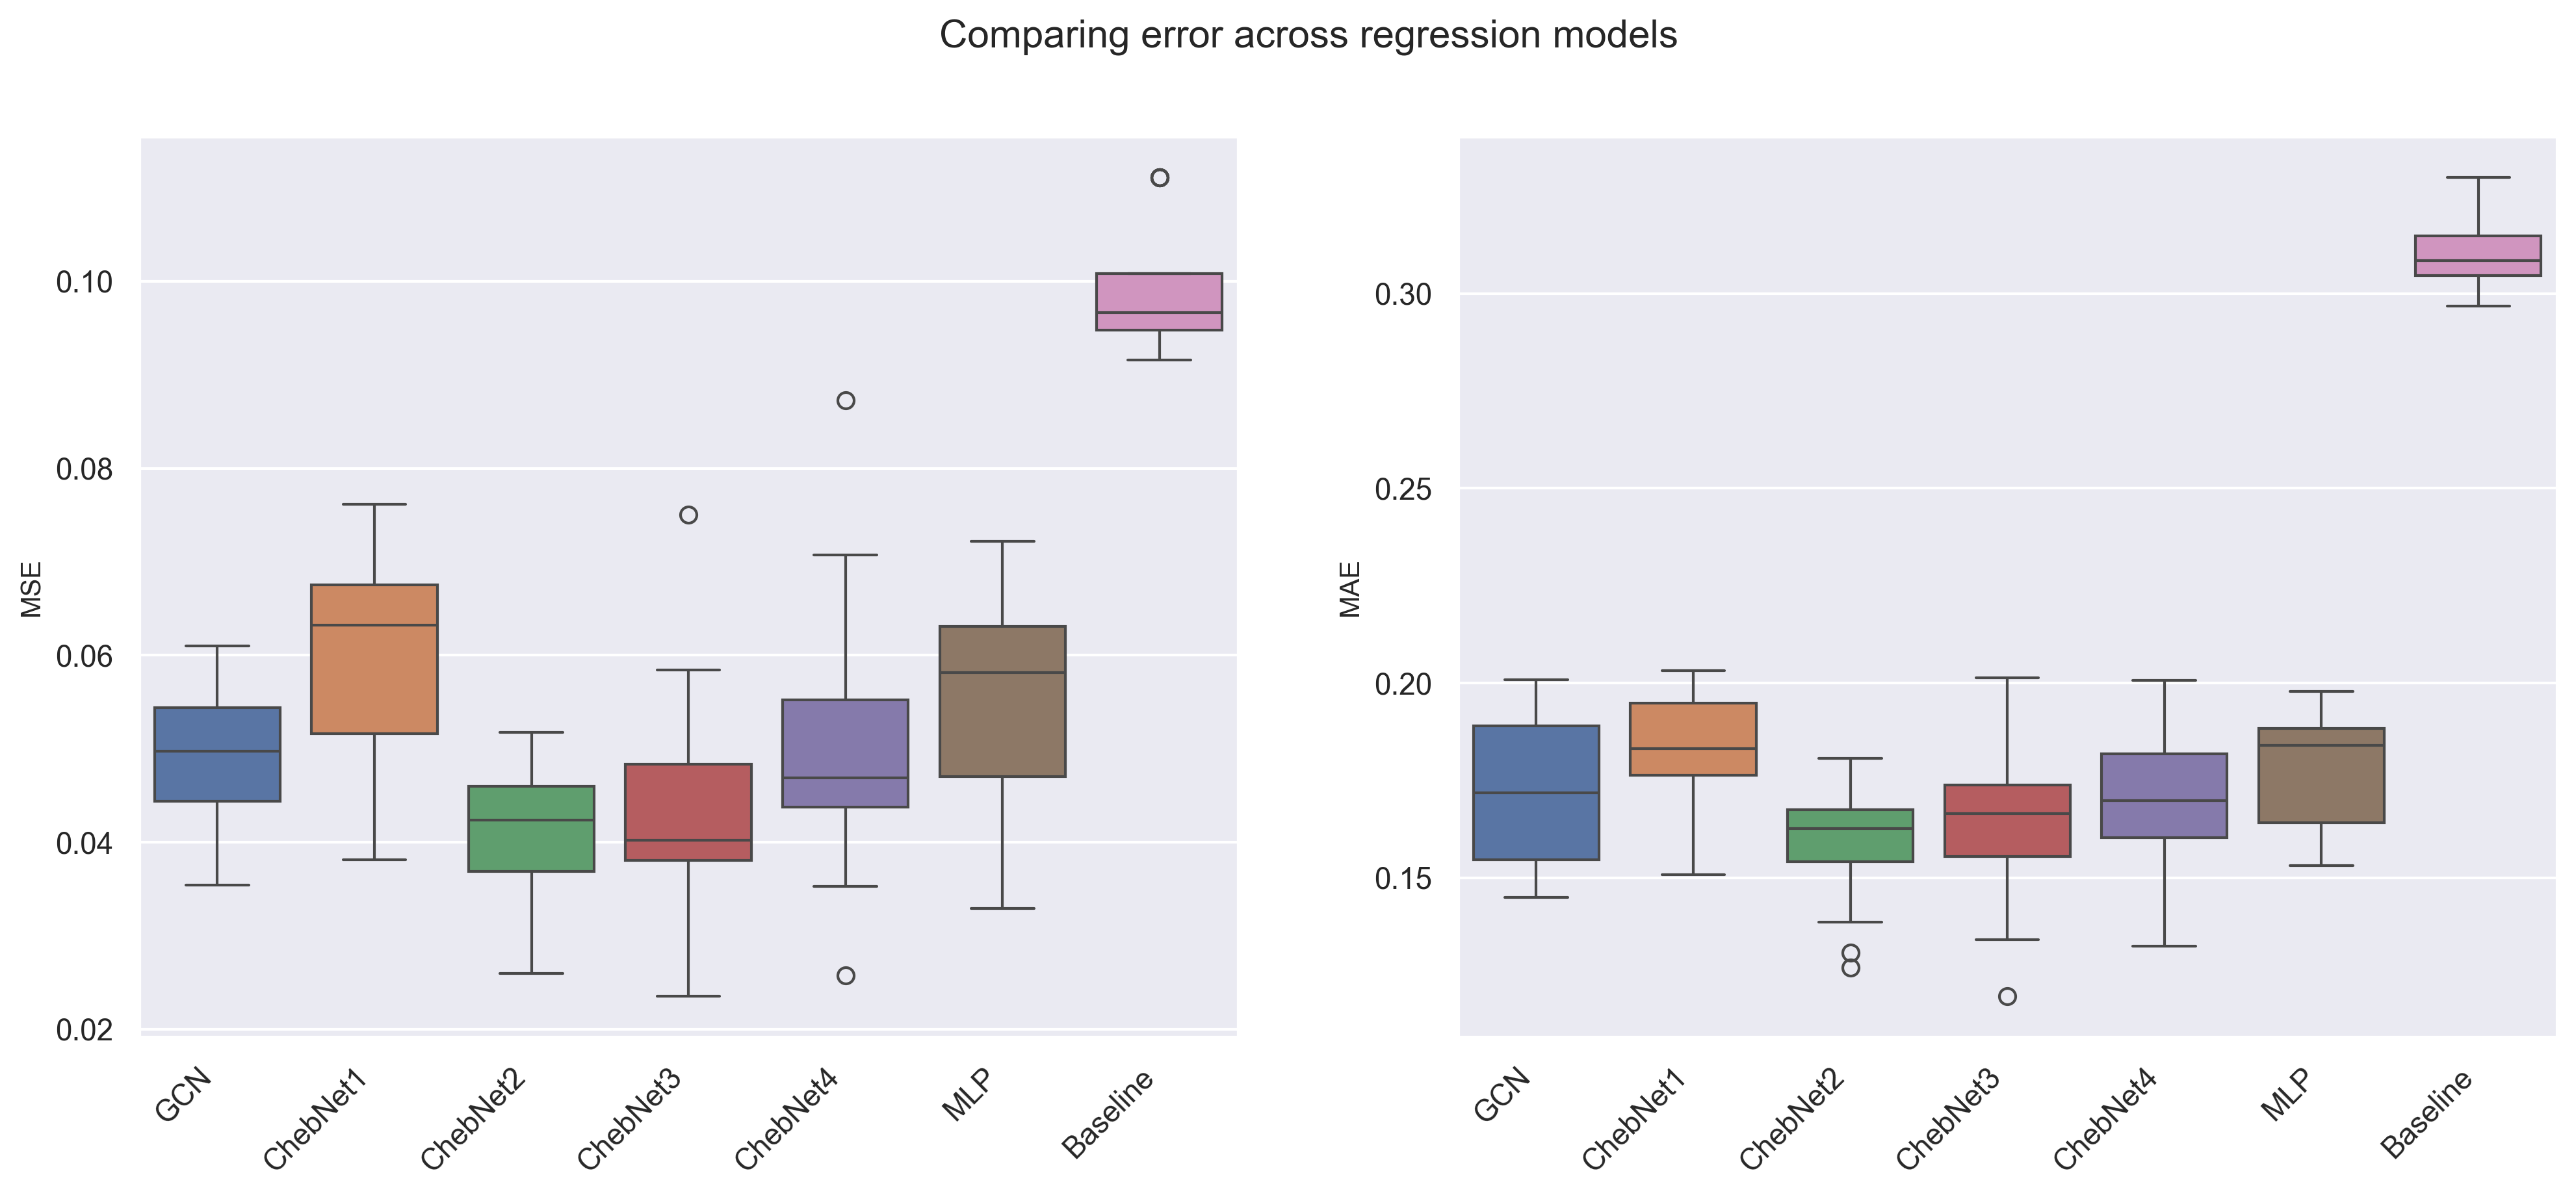

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

model_names = [ 'GCN','ChebNet1','ChebNet2','ChebNet3','ChebNet4', 'MLP', 'Baseline']

box_mse = np.reshape(MSE,(-1,num_splits*num_runs*num_trials))
box_mae = np.reshape(MAE,(-1,num_splits*num_runs*num_trials))

# Set the seaborn theme
sns.set_theme(style="darkgrid")

# Create subplots with 1 row and 2 columns
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(16, 6),dpi=300)

# Plot MSE
sns.boxplot(data=[box_mse[i] for i in range(len(model_names))], ax=axis1)
axis1.set_ylabel('MSE', fontsize=10)  # Set the font size for the y-axis label
axis1.set_xticklabels(model_names, rotation=45, ha='right')  # Set the x-axis tick labels

# Plot MAE
sns.boxplot(data=[box_mae[i] for i in range(len(model_names))], ax=axis2)
axis2.set_ylabel('MAE', fontsize=10)  # Set the font size for the y-axis label
axis2.set_xticklabels(model_names, rotation=45, ha='right')  # Set the x-axis tick labels

fig.suptitle('Comparing error across regression models')
plt.show()


In [10]:
nx.average_shortest_path_length(graph)

2.257989949748744

### Spatiotemporal GNNs

In [ ]:
import torch
import torch.nn as nn
import signatory
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GConvGRURegression,GConvLSTMRegression
from pygsig.graph import StaticGraphTemporalSignal, split_nodes
from pygsig.signature import SignatureFeatures

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_splits = 4
num_runs = len(seq_dataset)
num_trials = 5
num_epochs = 10
num_snapshots = 10000

learning_rate = 1e-4
lasso = 0
num_hidden = 16

print_during_training = False

# initialize models
models = []
models += [GConvGRURegression(num_channels=[dim, num_hidden, 1],K=2)]

mse_models = []
mae_models = []

for model in models:
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso)
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs,num_snapshots])
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs,num_snapshots])
    mse = np.zeros([num_splits, num_runs, num_trials,num_epochs])
    mae = np.zeros([num_splits, num_runs, num_trials,num_epochs])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,seed=31)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, seq in enumerate(seq_dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        for t,snapshot in enumerate(seq):
                            # train
                            model.train()
                            optimizer.zero_grad()
                            out = model(snapshot.x, snapshot.edge_index)
                            train_loss = criterion(out[train_mask], snapshot.y[train_mask])
                            train_loss.backward()
                            optimizer.step()
                            # evaluate
                            model.eval()
                            with torch.no_grad():
                                eval_loss = criterion(out[eval_mask], snapshot.y[eval_mask])
                                train_losses[split, run, trial, epoch,t] = train_loss.item()
                                eval_losses[split, run, trial, epoch,t] = eval_loss.item()
                            if epoch % 10 == 0 and print_during_training:
                                print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Test MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)


    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2,-1))
    avg_eval_losses = np.mean(eval_losses, axis=(0,1,2,-1))
    std_train_losses = np.std(train_losses, axis=(0,1,2,-1))
    std_eval_losses = np.std(eval_losses, axis=(0,1,2,-1))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
    plt.plot(avg_eval_losses,  label='Evaluation Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1,color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Loss Curves for {model._get_name()}')
    plt.legend()
    plt.show()